In [1]:
import os
import json
import gzip
from urllib.request import urlopen
import pandas as pd
import json
import altair as alt
import matplotlib.pyplot as plt
import seaborn
import numpy as np

## Parsing the compressed files and converting JSON data to Pandas DataFrames

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l.strip())

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./raw/Electronics_5.json.gz')
df_meta = getDF('./raw/electronics_metadata.json.gz')
df.shape, df_meta.shape

In [12]:
# percentage_nans = df.isna().sum() / len(df)
# percentage_nans_meta = df_meta.isna().sum() / len(df_meta)
percentage_nans

overall           0.000000
vote              0.859239
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.473645
reviewerName      0.000137
reviewText        0.000201
summary           0.000120
unixReviewTime    0.000000
image             0.982201
dtype: float64

We can drop Images column here because 98% of datapoints are missing also since we will not be using the review text for recommendation we will drop it for further analysis

In [21]:
df = df.drop(columns=['image','reviewTime'])
df['reviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df = df.drop(columns=['reviewText','summary','reviewerName','unixReviewTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6739590 entries, 0 to 6739589
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   overall         float64       
 1   vote            object        
 2   verified        bool          
 3   reviewerID      object        
 4   asin            object        
 5   style           object        
 6   reviewerName    object        
 7   reviewText      object        
 8   summary         object        
 9   unixReviewTime  int64         
 10  reviewTime      datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 572.0+ MB


In [22]:
df.drop('style', axis=1).nunique()

overall                 5
vote                 1171
verified                2
reviewerID         728719
asin               160052
reviewerName       513717
reviewText        5603451
summary           3340270
unixReviewTime       6835
reviewTime           6835
dtype: int64

We have 728719 unique users who rated 160052 unique products from Amazon Electronics Catalogue 

In [29]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786445 entries, 0 to 786444
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         786445 non-null  object
 1   tech1            786445 non-null  object
 2   description      786445 non-null  object
 3   fit              786445 non-null  object
 4   title            786445 non-null  object
 5   also_buy         786445 non-null  object
 6   tech2            786445 non-null  object
 7   brand            786445 non-null  object
 8   feature          786445 non-null  object
 9   rank             786445 non-null  object
 10  also_view        786445 non-null  object
 11  main_cat         786445 non-null  object
 12  similar_item     786445 non-null  object
 13  date             786445 non-null  object
 14  price            786445 non-null  object
 15  asin             786445 non-null  object
 16  imageURL         786445 non-null  object
 17  imageURLHi

We are interested in main_cat column which describes the main category, ASIN, price, date and title

In [32]:
# df_meta = df_meta[['asin','main_cat','title','price','date']]
df_meta = df_meta.drop_duplicates()
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756077 entries, 0 to 786444
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   asin      756077 non-null  object
 1   main_cat  756077 non-null  object
 2   title     756077 non-null  object
 3   price     756077 non-null  object
 4   date      756077 non-null  object
dtypes: object(5)
memory usage: 34.6+ MB


In [40]:
#cleaning meta DataFrame
df_meta = df_meta[~df_meta['main_cat'].str.contains('img src')]
df_meta['main_cat'] = df_meta['main_cat'].replace(r'^\s*$', 'others', regex=True)
df_meta

,asin,main_cat,title,price,date
0,0011300000,Camera &amp; Photo,Genuine Geovision 1 Channel 3rd Party NVR IP S...,$65.00,"January 28, 2014"
1,0043396828,Camera &amp; Photo,"Books ""Handbook of Astronomical Image Processi...",,"June 17, 2003"
2,0060009810,Books,One Hot Summer,$11.49,
3,0060219602,Books,Hurray for Hattie Rabbit: Story and pictures (...,.a-section.a-spacing-mini{margin-bottom:6px!im...,
4,0060786817,Books,sex.lies.murder.fame.: A Novel,$13.95,
...,...,...,...,...,...
786440,B01HJGOOMW,Portable Audio & Accessories,Tukzer Cassette Player Portable Tape Player Ca...,,"September 18, 2014"
786441,B01HJH3XLE,Computers,Cobiter AC Adapter Battery Charger For IBM LEN...,,"June 25, 2016"
786442,B01HJH6CEY,GPS & Navigation,Baofeng Original Li-ion Battery Charger Deskto...,,"June 25, 2016"
786443,B01HJH40WU,Cell Phones & Accessories,Jricoo 3pack 6ft Micro USB to USB Cable 2.0 6f...,,


In [46]:
df_meta.nunique()

asin        753050
main_cat        47
title       739186
price        13823
date          7316
dtype: int64

We have meta information about 753050 unique items belonging to 47 categories

In [54]:
cats = df_meta.groupby('main_cat').size().reset_index()
cats.columns = ['main_cat', 'count']
bars = alt.Chart(cats).mark_bar().encode(
    x='count:Q',
    y=alt.Y('main_cat', sort='-x')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count:Q'
)
(bars + text).properties(title='Categories vs Count in Meta Dataset' ,height=900)

alt.LayerChart(...)

Combining Meta information with reviews

In [59]:
# data = df.merge(df_meta,how='inner', left_on='asin', right_on='asin')
data

,overall,vote,verified,reviewerID,asin,style,reviewTime,main_cat,title,price,date
0,5.0,67,True,AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},1999-09-18,Books,The Last Life: A Novel,$13.81,
1,3.0,5,True,A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},2013-10-23,Books,The Last Life: A Novel,$13.81,
2,5.0,4,False,A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},2008-09-02,Books,The Last Life: A Novel,$13.81,
3,5.0,13,False,A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},2000-09-04,Books,The Last Life: A Novel,$13.81,
4,3.0,8,True,A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},2000-02-04,Books,The Last Life: A Novel,$13.81,
...,...,...,...,...,...,...,...,...,...,...,...
6725069,5.0,NaN,True,A1V2SN0SA23C9U,B01HIS365W,NaN,2017-01-03,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725070,5.0,NaN,False,A3MNHRPT1LDTSX,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725071,5.0,NaN,True,A136FYPECFL8XZ,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725072,1.0,NaN,True,A39P8TB9YS99V9,B01HIS365W,NaN,2016-07-29,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"


In [61]:
cats = data.groupby('main_cat').size().reset_index()
cats.columns = ['main_cat', 'count']
bars = alt.Chart(cats).mark_bar().encode(
    x='count:Q',
    y=alt.Y('main_cat', sort='-x')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count:Q'
)
(bars + text).properties(title='Which Categories recieve highest reviews?' ,height=900)

alt.LayerChart(...)

### Rating Distributions among categories

In [71]:
top10_cats = cats.sort_values('count', ascending=False)['main_cat'].values[:10]
ratings = data.groupby(['main_cat','overall']).size().reset_index()
ratings = ratings[ratings['main_cat'].isin(top10_cats)]
ratings.columns = ['main_cat','overall','count']
bars = alt.Chart(ratings).mark_bar().encode(
    x='overall:O',
    y=alt.Y('count'),
    facet='main_cat'
)
bars.properties(title='Rating Distribution among top 10 categories that recieve highest reviews')

alt.Chart(...)

## User Analysis

In [73]:
# Users with highest ratings
data

,overall,vote,verified,reviewerID,asin,style,reviewTime,main_cat,title,price,date
0,5.0,67,True,AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},1999-09-18,Books,The Last Life: A Novel,$13.81,
1,3.0,5,True,A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},2013-10-23,Books,The Last Life: A Novel,$13.81,
2,5.0,4,False,A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},2008-09-02,Books,The Last Life: A Novel,$13.81,
3,5.0,13,False,A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},2000-09-04,Books,The Last Life: A Novel,$13.81,
4,3.0,8,True,A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},2000-02-04,Books,The Last Life: A Novel,$13.81,
...,...,...,...,...,...,...,...,...,...,...,...
6725069,5.0,NaN,True,A1V2SN0SA23C9U,B01HIS365W,NaN,2017-01-03,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725070,5.0,NaN,False,A3MNHRPT1LDTSX,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725071,5.0,NaN,True,A136FYPECFL8XZ,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725072,1.0,NaN,True,A39P8TB9YS99V9,B01HIS365W,NaN,2016-07-29,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"


In [81]:
# usr = data.groupby('reviewerID').size().reset_index()
# usr.columns = ['reviewerID','count']
# usr = usr.sort_values('count', ascending=False)
bars = alt.Chart(usr.iloc[:50,:]).mark_bar().encode(
    x='count:Q',
    y=alt.Y('reviewerID', sort='-x')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count:Q'
)
(bars + text).properties(title='Top 50 Users with Highest number of reviews' ,height=900)

alt.LayerChart(...)

In [127]:
top50_users = usr.iloc[:50,:]['reviewerID'].values
usr_cat = data.groupby(['reviewerID','main_cat']).size().sort_values(ascending=False).reset_index()
a = usr_cat.groupby('reviewerID')[0].max().reset_index()
usr_cat = a.merge(usr_cat, how='inner', left_on=['reviewerID', 0], right_on=['reviewerID', 0])
usr_cat = usr_cat[usr_cat['reviewerID'].isin(top50_users)]
usr_cat.columns = ['reviewerID','count','main_cat']
a = usr_cat.groupby('main_cat').size().reset_index()
a.columns = ['main_cat','count']

bars = alt.Chart(a).mark_bar().encode(
    x='main_cat:N',
    y=alt.Y('count:Q')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dy=-5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count:Q'
)
(bars+text).properties(title='Categories reviewed by Top 50 Users with Highest number of reviews' ,width=900)

alt.LayerChart(...)

33 users of the top 50 users reviewed items from the Computers category highest number of times

In [198]:
data

,overall,vote,verified,reviewerID,asin,style,reviewTime,main_cat,title,price,date
0,5.0,67.0,True,AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},1999-09-18,Books,The Last Life: A Novel,$13.81,
1,3.0,5.0,True,A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},2013-10-23,Books,The Last Life: A Novel,$13.81,
2,5.0,4.0,False,A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},2008-09-02,Books,The Last Life: A Novel,$13.81,
3,5.0,13.0,False,A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},2000-09-04,Books,The Last Life: A Novel,$13.81,
4,3.0,8.0,True,A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},2000-02-04,Books,The Last Life: A Novel,$13.81,
...,...,...,...,...,...,...,...,...,...,...,...
6725069,5.0,0.0,True,A1V2SN0SA23C9U,B01HIS365W,NaN,2017-01-03,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725070,5.0,0.0,False,A3MNHRPT1LDTSX,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725071,5.0,0.0,True,A136FYPECFL8XZ,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725072,1.0,0.0,True,A39P8TB9YS99V9,B01HIS365W,NaN,2016-07-29,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"


In [202]:
verified = data.groupby('verified').agg({'vote': 'count', 'overall':'mean'}).reset_index()
verified.columns = ['verified', 'count','avg']

bars = alt.Chart(verified).mark_bar().encode(
    x='verified:N',
    y=alt.Y('count:Q')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dy=-5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='avg:Q'
)
(bars+text).properties(title='Number of verified users along with their Avg rating', width=300)

alt.LayerChart(...)

Most Helpful user

In [134]:
# https://stackoverflow.com/a/22137890/15751564
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')

data['vote'] = data['vote'].fillna(0)
data['vote'] = data['vote'].astype(str).map(atof)

,overall,vote,verified,reviewerID,asin,style,reviewTime,main_cat,title,price,date
0,5.0,67,True,AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},1999-09-18,Books,The Last Life: A Novel,$13.81,
1,3.0,5,True,A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},2013-10-23,Books,The Last Life: A Novel,$13.81,
2,5.0,4,False,A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},2008-09-02,Books,The Last Life: A Novel,$13.81,
3,5.0,13,False,A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},2000-09-04,Books,The Last Life: A Novel,$13.81,
4,3.0,8,True,A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},2000-02-04,Books,The Last Life: A Novel,$13.81,
...,...,...,...,...,...,...,...,...,...,...,...
6725069,5.0,NaN,True,A1V2SN0SA23C9U,B01HIS365W,NaN,2017-01-03,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725070,5.0,NaN,False,A3MNHRPT1LDTSX,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725071,5.0,NaN,True,A136FYPECFL8XZ,B01HIS365W,NaN,2016-11-19,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"
6725072,1.0,NaN,True,A39P8TB9YS99V9,B01HIS365W,NaN,2016-07-29,Computers,Lightning microSD Card Reader for iPhone and iPad,,"June 22, 2016"


In [151]:
# vote = data.groupby('reviewerID')['vote'].mean().reset_index()
# vote = vote.sort_values('vote', ascending=False)
# vote.columns = ['reviewerID','avg_votes']

bars = alt.Chart(vote.iloc[:50,:]).mark_bar().encode(
    x='avg_votes:Q',
    y=alt.Y('reviewerID:N', sort='-x')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='avg_votes:Q'
)
(bars+text).properties(title='Top 50 Users with most Helpful reviews', width=300)

alt.LayerChart(...)

Are the users with Highest number of reviews Helpful?

In [152]:
a = set(vote.iloc[:50,:]['reviewerID'].values)
b = set(top50_users)
print('Number of Top Helpful Users: {}'.format(len(a.intersection(b))))

Number of Top Helpful Users: 0


Surprising! These top 50 users with highest number of reviews don't leave a Helpful review we can consider them as some kind of spammers

## Product Analysis

Top 50 products with highest number of ratings and Average Ratings

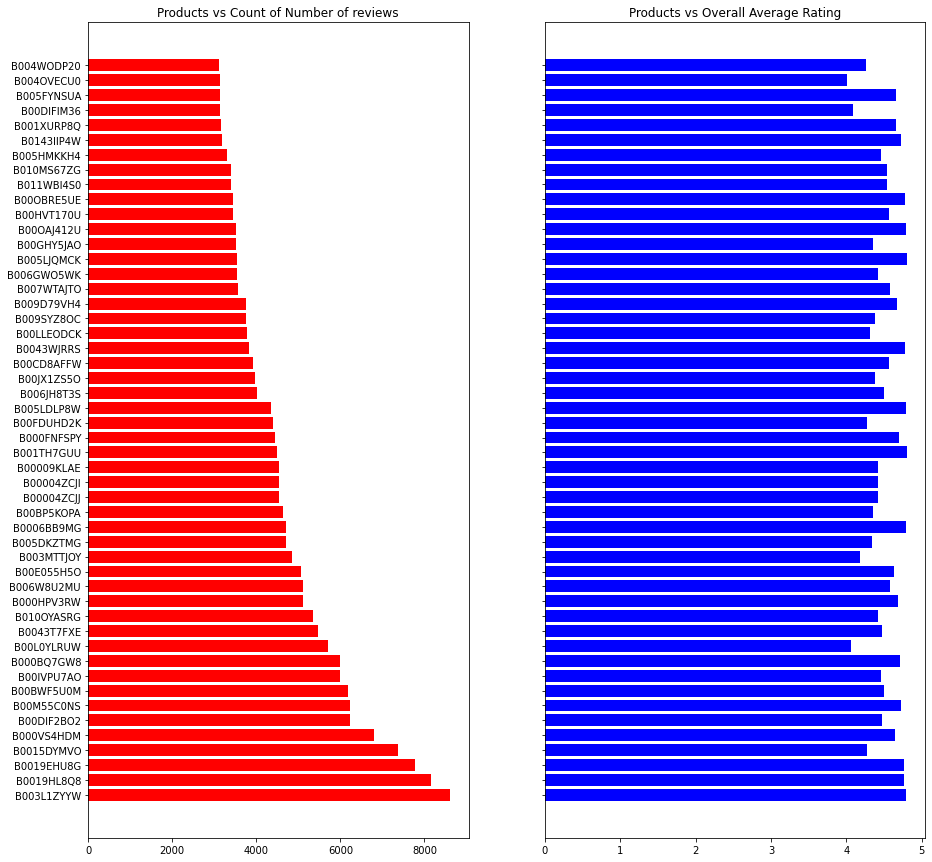

In [182]:
asin = data.groupby(['asin']).size().reset_index()
asin.columns = ['asin','count']
asin = asin.sort_values('count', ascending=False)
asin = asin.iloc[:50,:]

top50_asin = asin['asin'].values
avg_asin = data.groupby(['asin'])['overall'].mean().reset_index()
avg_asin.columns = ['asin','overall']
avg_asin = avg_asin[avg_asin['asin'].isin(top50_asin)]
avg_asin = avg_asin.drop_duplicates()
avg_asin.shape, asin.shape

asin = asin.merge(avg_asin, how='inner', left_on='asin', right_on='asin')

f, ax = plt.subplots(1,2, sharey=True, figsize=(15, 15))
ax[0].barh(asin['asin'], asin['count'], align='center', color='red')
ax[0].title.set_text('Products vs Count of Number of reviews')
ax[1].barh(asin['asin'], asin['overall'], align='center', color='blue')
ax[1].title.set_text('Products vs Overall Average Rating')

It looks like people really like B003L1ZYYW, B0019HL8Q8 and B0019EHU8G products are really liked by the users, They have the highest number of reviews and te average rating is also high

Text(0.5, 0.98, 'Histogram of Reviews and Average Ratings')

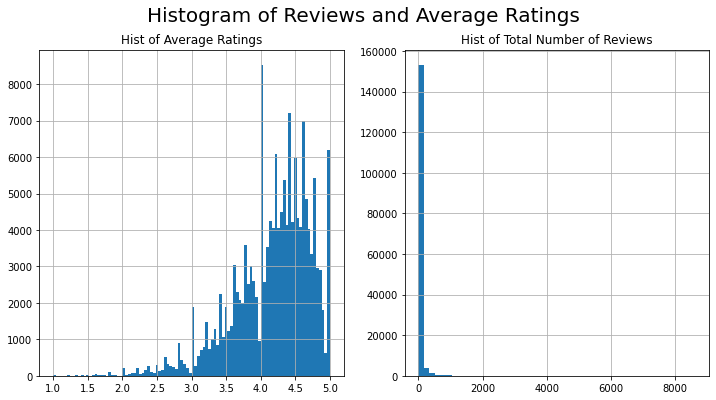

In [197]:
# avg_asin = data.groupby(['asin'])['overall'].mean().reset_index()
# asin = data.groupby(['asin']).size().reset_index()
f, ax = plt.subplots(1,2, figsize=(12, 6))
avg_asin['overall'].hist(bins=100, ax=ax[0])
ax[1].title.set_text('Hist of Total Number of Reviews')
asin[0].hist(bins=50, ax=ax[1])
ax[0].title.set_text('Hist of Average Ratings')
f.suptitle('Histogram of Reviews and Average Ratings', fontsize=20)

Most of the products recieved reviews from 1-1000 users and Majority of the products have their average rating slightly above 4.0 

# Time Series Analysis

In [206]:
ts = data[data['main_cat'].isin(top10_cats)]
ts

MemoryError: Unable to allocate 343. MiB for an array with shape (7, 6418545) and data type object

MemoryError: Unable to allocate 97.9 MiB for an array with shape (2, 6418545) and data type float64